# 정선아(17011709), 문성용(17011741), 김소영(17011742)

# 1. PIP

### 1.1 기존 유사도 측정방법의 문제점

a. 데이터 sparsity에 따라 매우 제한된 수의 공동 평가. <br>
b. 공통 레이팅 항목 수가 1개일 경우, COR을 계산할 수 없고 COS은 1개의 상관없는 개인 레이팅 차이를 발생시킨다. <br>
c. 주어진 레이팅이 모두 <1, 1, 1>, <3, 3, 3>, <4, 4, 4>와 같은 flat한 상태라면 두 유저 사이의 COS은 측정될 수 없다. <br>
d. 두개의 벡터가 <2, 2>, <3, 3>과 같이 같은 선상에 존재하면 COS은 두개의 의미없는 차이를 발생시킨다. <br>
e. COR, COS는 종종 오류를 발생시킨다. 매우 먼 관계에 있는 유저들의 유사도가 가깝게 측정 될 수 있다. <br><br>
이와 같은 문제들은 레이팅의 수가 굉장히 제한적이거나 데이터셋이 sparse한 경우 더 심각한 문제를 불러 일으킬 수 있다. 왜냐하면 유사도 측정법 계산보다 우연에 의해 발생할 가능성이 더 크기 때문이다. 


### 1.2 새로운 유사도 측정법: PIP (Proximity-Impact-Popularity) 

a. 이 조치는 콜드 스타트 권장 조건에 더 효과적이기 위해 전통적인 유사성 또는 거리 측정만 채택하지 말고 데이터의 도메인 고유 의미를 활용한다. <br>
b. 좀 더 실용화하기 위해서는 방대한 재구축이나 추가 데이터 수집이 필요 없이 시스템의 유사성 측정법만 교체해 기존 CF 시스템에 쉽게 
   플러그인을 할 수 있도록 해야 한다. <br>
c. 이 조치는 새로운 사용자 콜드 스타트 조건에서 더 나은 결과를 보여줄 뿐만 아니라 콜드 스타트 이외의 다른 인기 있는 조치와 비교 가능한 결과를 보인다.

### 1.3 PIP 수식

PIP 측정법은 Proximity, Impact, Popularity의 3가지 요소로 이루어져 있다. PIP 측정법은 다음의 수식을 통해 u_i, u_j의 유사도를 측정한다. 

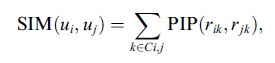
a. r_ik, r_jk는 아이템 k에 대한 user i, user j의 rating이다. <br>
b. C_ij는 user i와 user j가 rating한 아이템의 집합니다. <br>
c. PIP(r_ik r_jk)는 r_ik, r_jk에 대한 PIP score이다. <br>
d. PIP(r1, r2) = Proximity(r1, r2) x Impact(r1, r2) x Popularity(r1, r2)

### 1.4 각 요소별 의미

a. Proximity <br>
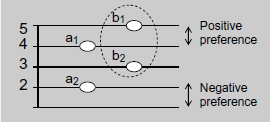
(a1, a2), (b1, b2)모두 2라는 같은 거리값을 가지고 있다. 하지만 첫번째 쌍은 a1은 긍정적인 rating인 반면, a2는 부정적인 rating값이라서 이에 패널티가 부과되어야 한다.
반면 b1은 긍정적인 rating이고, b2는 중립이기때문에 패널티를 부과하지 않는다.

b. Impact
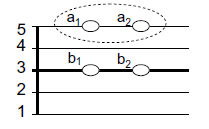
(a1, a2), (b1, b2)모두 0의 거리값을 가진다. 하지만 첫번째 쌍은 더 강한 선호도 값에서 동의를 보여주므로 더 큰 영향을 미치는 것으로 여겨진다. 

c. Popularity
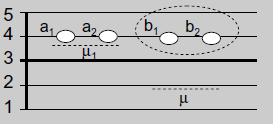
(a1, a2), (b1, b2) 모두 0의 거리값을 가지므로 같은 Impact요소를 가진다. 하지만 Mu를 모두 측정된 아이템의 평균이라고 할때, 둘 사이의 유사도는 Mu1의 평균을 같는 쌍보다 더 큰 값을 같는다. 

### 1.5 Agreement 함수 구현

Agreement 함수는 boolean function으로 여기서 r_max와 r_min은 레이팅의 최대 가능값, 최소 가능값을 의미한다. 

In [27]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn import preprocessing
from collections import OrderedDict 

In [28]:
def Agreement(r1, r2):
    if (r1 > r_med and r2 < r_med) or (r1 < r_med and r2 > r_med):
        return False
    
    return True

### 1.6 Proximity 함수 구현

Agreement(r1, r2)값의 True, False 두가지에 나눠 distance를 구한다. 

In [29]:
def Proximity(r1, r2):
    if Agreement(r1, r2):
        D = abs(r1 - r2)
    else:
        D = abs(r1 - r2) * 2
        
    return ((2 * (r_max - r_min) + 1) - D)**2

### 1.7 Impact 함수 구현

Agreement값에 따라 두가지 리턴 값을 갖는다. 

In [30]:
def Impact(r1, r2):
    if Agreement(r1, r2):
        return (abs(r1 - r_med) + 1) * (abs(r2 - r_med) + 1)
    else:
        return 1 / ((abs(r1 - r_med) + 1) * (abs(r2 - r_med) + 1))

### 1.8 Popularity 함수 구현

Mu_k는 아이템 k에 대한 모든 유저의 평균

In [31]:
def Popularity(r1, r2, k): # k는 아이템
    rating = np.array(MovieLens_pivot[k].values)
    #mu_k = np.nanmean(np.where(rating != 0, rating, np.nan))
    mu_k = rating.mean()
    if (r1 > mu_k and r2 > mu_k) or (r1 < mu_k and r2 < mu_k):
        return 1 + (((r1 + r2) / 2) - mu_k)**2
    else:
        return 1

### 1.9 PIP 구현

user i, user j가 레이팅한 모든 아이템에 대하여 PIP를 측정하고 SUM한다.

In [32]:
# 변수 초기화
r_max = 5
r_min = 1
r_med = (r_max + r_min) / 2

In [33]:
# PIP 함수 
def PIP(user1, user2):
    shared_item = []
    r1_item = np.array(MovieLens_pivot.loc[user1].values > 0, dtype = np.int)
    r2_item = np.array(MovieLens_pivot.loc[user2].values > 0, dtype = np.int)
    union = r1_item + r2_item
    for i in range(len(union)):
        if union[i] == 2:
            shared_item.append(MovieLens_pivot.columns[i])
    if len(shared_item) == 0:
        return 0
    
    sim_pip = 0
    for item in shared_item:
        r1 = MovieLens_pivot.loc[user1][item]
        r2 = MovieLens_pivot.loc[user2][item]
        sim_pip += Proximity(r1, r2) * Impact(r1, r2) * Popularity(r1, r2, item)
        
    return sim_pip

### 1.10 MovieLense Data를 이용하여 모든 유저의 PIP Similarity 측정

In [34]:
# 앞선 과제에서 가공한 MovieLens Data ->>>>>>>>>>>>>>모듈화해서 불러올 필요 있음
MovieLens_df = pd.read_table("ratings.dat", sep='::', header=None, names=['UserID','MovieID','Rating','Timestamp'])
MovieLens_df.drop(['Timestamp'], axis=1, inplace=True)
MovieLens_pivot = MovieLens_df.pivot_table(index='UserID', columns='MovieID', values='Rating')
row_index = MovieLens_pivot.isnull().sum(axis = 1).sort_values() # NaN이 적은 순으로 행 뽑아내기
MovieLens_pivot = pd.DataFrame(MovieLens_pivot, index=row_index.index)
MovieLens_pivot = MovieLens_pivot.iloc[:1000,:]
col_index = MovieLens_pivot.isnull().sum(axis = 0).sort_values() # NaN이 적은 순으로 열 뽑아내기
MovieLens_pivot = pd.DataFrame(MovieLens_pivot, columns=col_index.index)
MovieLens_pivot = MovieLens_pivot.iloc[:,:1000]
user_index = MovieLens_pivot.index.values # User ID 기억하기
user_index = pd.Series(user_index) # Index rename 인자로 넣기 위해 형태 변경
MovieLens_pivot.fillna(0, inplace=True)
MovieLens_pivot = MovieLens_pivot.astype('int64')

In [35]:
MovieLens_pivot = MovieLens_pivot.iloc[:20, :20] # 테스트 할려고 크기 줄임

In [36]:
# 변수 초기화
size = np.size(MovieLens_pivot, axis = 0)
simPIP = np.zeros(shape = (size, size)) # 0으로 초기화 된 행렬 생성

# for문을 통한 각 유저별 PIP Similarity 측정
for u, i in zip(MovieLens_pivot.index, range(len(MovieLens_pivot))):
    for v, j in zip(MovieLens_pivot.index, range(len(MovieLens_pivot))):
        #print(u, i, v, j)
        sim = PIP(u, v)
        simPIP[i][j] = sim
        simPIP[j][i] = sim
                    
# 측정된 값을 MinMaxScaler를 이용해 정규화                
min_max_scaler = preprocessing.MinMaxScaler()
simPIP = min_max_scaler.fit_transform(simPIP)
df_simPIP = pd.DataFrame(index = MovieLens_pivot.index, columns = MovieLens_pivot.index, data = simPIP)
df_simPIP

UserID,4169,1680,4277,1941,1181,889,3618,2063,1150,1015,5795,4344,1980,2909,1449,4510,424,4227,5831,3391
UserID,,,,,,,,,,,,,,,,,,,,
4169,0.961887,0.631936,0.641655,0.386890,0.191896,0.371696,0.664753,0.221193,0.050010,0.708586,0.358854,0.493177,0.708694,0.700351,0.170022,0.515656,0.626765,0.556779,0.711687,0.634967
1680,0.576624,1.000000,0.534942,0.249654,0.326058,0.458472,0.270888,0.134529,0.050829,0.538269,0.292956,0.249266,0.443788,0.577639,0.288156,0.339847,0.579847,0.417608,0.608117,0.460879
4277,0.924012,0.818965,1.000000,0.489781,0.653572,0.854020,0.699263,0.507349,0.008903,0.962257,0.489821,0.633773,0.984970,0.906305,0.211903,0.568317,0.962838,0.884251,0.947897,0.897701
1941,0.665146,0.449767,0.602098,1.000000,0.304520,0.788724,0.730474,0.142512,0.030780,0.541761,0.370927,0.277760,0.515633,0.734426,0.000000,0.715735,0.632887,0.686960,0.523203,0.555457
1181,0.044681,0.158955,0.270930,0.097771,1.000000,0.696928,0.000000,0.072648,0.064886,0.294068,0.019784,0.141309,0.151254,0.184297,0.356898,0.043052,0.243752,0.344658,0.369012,0.216836
889,0.094923,0.176365,0.296003,0.213512,0.572607,1.000000,0.185139,0.089425,0.000562,0.329140,0.056337,0.121312,0.201540,0.207535,0.053566,0.160669,0.272692,0.390106,0.329499,0.228578
3618,0.054729,0.000000,0.100724,0.072852,0.000000,0.139377,0.570610,0.000000,0.089477,0.103747,0.062766,0.000000,0.099090,0.108002,0.108300,0.084462,0.119096,0.107531,0.172391,0.093464
2063,0.220807,0.174515,0.361411,0.116343,0.260875,0.385311,0.500562,1.000000,0.075585,0.358826,0.236337,0.485225,0.344340,0.288648,0.307917,0.275778,0.528959,0.335826,0.508387,0.399623
1150,0.000000,0.025509,0.000000,0.012972,0.177794,0.000000,0.871895,0.043562,1.000000,0.000000,0.275940,0.134391,0.000000,0.000000,0.590044,0.337783,0.000000,0.000000,0.000000,0.000000


# 2. Singularity

### 2.1 Singularity의 동기

RS에서 CF의 핵심은 추천하고자하는 사용자에게 k-neighbors의 선택이다. 이 과정은 흔히 이용 가능한 모든 정보를 이용하지 않는 유사성 측정을 사용함으로써 달성되는 경우가 많으며, 더욱이 이용되는 정보는 예상한 것보다 훨씬 덜 목적적합하게 된다. rating값을 분류하는 것뿐만 아니라 상황적 맥락정보(contextual information, 이용자 전체에서 도출)를 활용한 결과의 개선을 도모할 것이다.

### 2.2 Contextual information의 의미

앞선 전통적인 유사도 측정은 두 사용자가 레이팅한 값만을 고려하여 계산된다. 대부분 효율적으로 계산되지만, 유저들에 의해 만들어진 레이팅에 대한 맥락은 무시된다. Singularity는 유저가 만든 각 항목의 등급을 분석하여 이러한 맥락을 고려한다. 
만약 두 명의 유저가 투표한 표가 한 항목에 대해 유사하다면, 이는 해당 유저와 나머지 사용자 간에 찾기 어려운 유사성을 나타내기 때문에 다른 사용자가 투표한 항목이 서로 다를 경우 우리는 더 많은 가치를 갖는다. 한편, 대다수의 유저가 유사한 방식으로 어떤 항목에 대해 투표했다면, 나머지 유저와 동일한 방식으로 이 항목에 대해 투표한 두 유저 간의 유사성은 그다지 관련이 없다고 보아야 한다.

### 2.3 Singularity의 개념의 통합

Singularity는 두 유저에게 할당된 유사성에 대한 항목의 기여는 절대적으로 간주되는 것이 아니라 데이터 전체 나머지 유저가 항목에 레이팅한 값을 비교하여 고려되어야 한다는 것이다. 특이한 유사성이 정상적인 유사성보다 더 높은 값을 부여하는 방식으로 유사성의 가치를 특이성 값으로 변조한다는 것이다. 

### 2.4 Basic model 구현 

U: user의 전체 집합, I: item의 전체 집합 <br>
R: 긍정의 relevence 집합(MovieLens Data에서는 4, 5)<br>
P_i: 아이템 i에 대하여 긍정적으로 rating한 user(threshold = 4)<br>
N_i: 아이템 i에 대하여 부정적으로 rating한 user<br>
S_pi: 1 - len(P_i) / len(U) <br>
S_ni: 1 - len(N_i) / len(U) <br>
S_pi + S_ni = 1

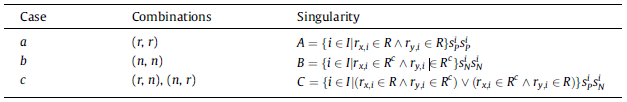

위 표에 따라 user1, user2의 rating을 보고 집합 A, B, C를 할당한다.

In [37]:
# 변수 초기화
threshold = 4 # 4점 이상의 레이팅을 positive로 보겠음
R = [4, 5] # positive rating value
Rc = [1, 2, 3] # non-positive rating value
singularity = OrderedDict()
P = OrderedDict()
N = OrderedDict()
Sp = OrderedDict()
Sn = OrderedDict()
items = MovieLens_pivot.columns
users = MovieLens_pivot.index

In [38]:
# user, item에 해당하는 rating값 반환
def getRating(user, item):
    return MovieLens_pivot.loc[user][item]

In [39]:
# P_i, N_i
for item in items:
    pvalues = []
    nvalues = []
    for user in users:
        if MovieLens_pivot.loc[user][item] in R:
            pvalues.append(user)
        else:
            nvalues.append(user)
    P[item] = pvalues
    N[item] = nvalues

In [40]:
# S_pi, S_ni
for item in items:
    value = 1 - len(P[item]) / len(MovieLens_pivot)
    Sp[item] = value
    Sn[item] = 1 - value

In [41]:
# user1, user2의 singularity similarity 측정
def Singularity(user1, user2):
    # P_i, N_i
    P = OrderedDict()
    N = OrderedDict()
    for item in items:
        pvalues = []
        nvalues = []
        for user in users:
            if MovieLens_pivot.loc[user][item] in R:
                pvalues.append(user)
            else:
                nvalues.append(user)
        P[item] = pvalues
        N[item] = nvalues
        
    # S_pi, S_ni
    Sp = OrderedDict()
    Sn = OrderedDict()
    for item in items:
        value = 1 - len(P[item]) / len(MovieLens_pivot)
        Sp[item] = value
        Sn[item] = 1 - value    
    
    #similarity    
    A = np.array([])
    B = np.array([])
    C = np.array([])
    for item in items:
        rating1 = getRating(user1, item)
        rating2 = getRating(user2, item)
        if (rating1 in R) and (rating2 in R):
            singularity[item] = Sp[item]**2
            A = np.append(A, item)
        elif (rating1 in Rc) and (rating2 in Rc):
            singularity[item] = Sn[item]**2
            B = np.append(B, item)
        else:
            singularity[item] = Sp[item] * Sn[item]
            C = np.append(C, item)
    simSING = ((sum([((1 - (getRating(user1, item) - getRating(user2, item))**2) * Sp[item]**2) for item in A]) / len(A)
               if len(A) > 0 else 0)
             + (sum([((1 - (getRating(user1, item) - getRating(user2, item))**2) * Sn[item]**2) for item in B]) / len(B) 
               if len(B) > 0 else 0)
            + (sum([((1 - (getRating(user1, item) - getRating(user2, item))**2) * Sp[item] * Sn[item]) for item in C]) / len(C) 
               if len(C) > 0 else 0)) / 3.0
    
    return simSING

In [42]:
# 결과 행렬값 초기화
size = np.size(MovieLens_pivot, axis = 0)
simSING = np.zeros(shape = (size, size)) # 0으로 초기화 된 행렬 생성

# for문을 통한 각 유저별 Singularity Similarity 측정
for u, i in zip(MovieLens_pivot.index, range(len(MovieLens_pivot))):
    for v, j in zip(MovieLens_pivot.index, range(len(MovieLens_pivot))):
        #print(u, i, v, j)
        sim = Singularity(u, v)
        simSING[i][j] = sim
        simSING[j][i] = sim

# 측정된 값을 MinMaxScaler를 이용해 정규화  
min_max_scaler = preprocessing.MinMaxScaler()
simSING = min_max_scaler.fit_transform(simSING)
df_simSING = pd.DataFrame(index = MovieLens_pivot.index, columns = MovieLens_pivot.index, data = simSING)
df_simSING

UserID,4169,1680,4277,1941,1181,889,3618,2063,1150,1015,5795,4344,1980,2909,1449,4510,424,4227,5831,3391
UserID,,,,,,,,,,,,,,,,,,,,
4169,1.000000,0.570645,0.897099,0.656875,0.700373,0.608915,0.801381,0.581729,0.150879,0.863820,0.682802,0.698074,0.848979,0.807700,0.438811,0.623120,0.911321,0.542279,0.879545,0.871827
1680,0.607436,1.000000,0.776923,0.709593,0.701690,0.658236,0.716509,0.552492,0.101877,0.694209,0.373553,0.571010,0.660255,0.769602,0.191135,0.449372,0.877416,0.580765,0.749634,0.787921
4277,0.659767,0.421758,1.000000,0.552660,0.568615,0.541392,0.563489,0.459375,0.196659,0.670159,0.357034,0.544332,0.680093,0.358648,0.090924,0.222377,0.992848,0.002046,0.656216,0.996788
1941,0.548264,0.587400,0.760738,1.000000,0.000000,0.544702,0.593328,0.409418,0.053216,0.615017,0.184304,0.473597,0.476564,0.805368,0.120216,0.216032,0.795864,0.707420,0.571855,0.751438
1181,0.756396,0.691505,0.869005,0.261068,1.000000,0.806448,0.805943,0.661260,0.493243,0.768449,0.699948,0.731076,0.670869,0.802249,0.664289,0.671819,0.931913,0.798534,0.805222,0.870277
889,0.603877,0.616175,0.827142,0.641839,0.777228,1.000000,0.752363,0.632146,0.392083,0.706559,0.353371,0.542919,0.692328,0.751211,0.419600,0.326402,0.876885,0.791010,0.684491,0.819733
3618,0.872306,0.723798,0.899428,0.750535,0.804168,0.793586,1.000000,0.778399,0.456058,0.913877,0.523950,0.762903,0.860973,0.867626,0.701892,0.826150,0.950937,0.818597,0.945356,0.903480
2063,0.600670,0.539377,0.799170,0.566531,0.641304,0.651695,0.738141,1.000000,0.413116,0.727335,0.408433,0.764988,0.708747,0.699777,0.605083,0.434115,0.910137,0.686231,0.713425,0.846897
1150,0.150898,0.158858,0.666360,0.321399,0.515901,0.464413,0.376218,0.446104,1.000000,0.524762,0.660496,0.353613,0.216429,0.702553,0.339059,0.182700,0.794970,0.672474,0.205272,0.709336
